Regression 
This is dataset containing over 21613 houses and their characteristics, the goal is to find the best model to predict a house’s price : 

1. Explore this dataset using what you have learned in data preprocessing and data visualization 

2. Write a paragraph selecting the most important features (feature selection). 

3. Split your dataset into a training set and a testing set. 

4. Apply Linear regression to your training set. 

5. Plot the linear regression. 

5. Measure the performance of linear regression using the testing set. 

6. Apply multi-linear regression and compare it to the linear model. 

7. Apply Polynomial regression and compare it to the linear and multilinear regression. 

Note: Every result has to be interpreted and justified (write your interpretations in a markdown).

# Data Analyse et Creation du Model de Regression :
# --  Detection Prix Masion -- Seatel

In [1]:
#Importing libraries
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

sns.set_style("darkgrid")

# My Fonctions

In [2]:
def sqft_to_sqmt(sq): return round(sq/(10.76391),2)
def sqmt_to_sqft(sm): return sm*(10.76391)

def prGTitle(txt): print("\n\033[1m  {}\033[00m " .format(txt)) 
def prSTitle(txt): print("\n\033[4m {}\033[00m " .format(txt)) 
def prPargB(txt): print("\033[34m   {}\033[00m " .format(txt))
def prPargG(txt): print("\033[90m   {}\033[00m " .format(txt))
def praParST(Stitle,Parg):
    prSTitle(Stitle)
    prPargB(Parg)    

def rapport_data(df):  
    prGTitle('Report de notre Data')
    praParST('Target :', target_df)
    praParST('Shape of dataframe :',df.shape)
    praParST('Columns of dataframe :',df.columns)
    praParST('Features and Data Types:',df.dtypes.value_counts())

def rapport_nan(df, agg=True):
    if agg:
        prGTitle('Report de notre Data')
        praParST('Features with Nan :', [prPargB(ind) for ind in (df.columns[df.isna().sum() != 0])])
    else :
        return  df.columns[df.isna().sum() != 0]

def features_type(df, agg=True, min_unique=20):
    numeric_list, cat_list , other_list = [] , [], []
    [cat_list.append(col) if df[col].nunique() < min_unique else None for col in df]
    cat_list.sort() 

    [numeric_list.append(col) if (df[col].dtypes) == 'int64' or (df[col].dtypes) == 'float64' else other_list.append(col) for col in df]
    
    numeric_list.remove(target_df)
    numeric_list.sort()

    if agg :
        prGTitle('Feature by dType')
        praParST('Numerical Feature', numeric_list)         
        praParST('Other Type Feature', other_list)
        praParST('Feature with a reduced number of variables', cat_list)
    else :
        return numeric_list, cat_list , other_list

    

def outlier(df, col, s=2, out=True):
    mean , std, z_score = np.mean(df[col]) , np.std(df[col]), 0
    out_outliers, in_outliers = [], []
    if s < df[col].unique().size :
        for y in df[col]:
            z_score = (y - mean) / std 
            if np.abs(z_score) > s:
                out_outliers.append(int(y))
            else :
                in_outliers.append(int(y))
    
    if out: return list(set(out_outliers)) 
    else :  return list(set(in_outliers))

def col_frequency(df, col_ = '', agg = False):
    col = col_
    if type(col_) is not list: col_ = list(col_.split(" "))
        
    if agg :
        prGTitle(f'Fréquence : {col}')
        praParST(f'"{col}" variation',  f'{df[col].min()  :-<30} {df[col].max()}')
        praParST('', f'"{col}" moyenne   \t {round(df[col].mean(),2)} \t median {df[col].median()} \t quantile {round(df[col].quantile(.99),2)}')
    frequence = { col: {'Min' : df[col].min(),
                        'Madian' : df[col].median(),
                        'Quantil .99' : df[col].quantile(.99),
                        'Max' : df[col].max()} for col in col_}
    return pd.DataFrame(data=frequence).transpose() 

def corr_df(df, grf= False, target= ''):
    corr = data.corr()
    
    target_cr,  tar_hight_corr, tar_low_corr=  target, [], []
    columns, rows = corr.columns, corr.index
    
    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            corr_test =  corr.iloc[i,j]
            if corr_test <= -0.5 or corr_test >= 0.5:
                if columns[i] == target_cr or rows[i] == target_cr: 
                    tar_hight_corr.append(tuple([columns[i], rows[j], round(corr_test,2)]))
            elif corr_test >= -0.2 and corr_test <= 0.2: None
            elif columns[i] == target_cr or rows[i] == target_cr: 
                    tar_low_corr.append(tuple([columns[i], rows[j], round(corr_test,2)]))
    tar_hight_corr.sort(key=lambda tup: tup[2], reverse=True)
    tar_low_corr.sort(key=lambda tup: tup[2], reverse=True)
    f_hight =  {target_cr: { col_2 : cor  for col_1,col_2,cor in tar_hight_corr + tar_low_corr}} 
    f_hight = pd.DataFrame(data = f_hight)  
    if grf:
        prGTitle(f'Corrélation with {target}')
        [prSTitle('Hight Correlation') if tar_hight_corr else print('Not Hight Correlation')]  
        [[prPargB(ind) for ind in (tar_hight_corr)] if tar_hight_corr else None]    
        [prSTitle('Low Correlation') if tar_low_corr else print('Not Low Correlation')] 
        [[prPargB(ind) for ind in (tar_low_corr)] if tar_low_corr else None]  
    else :
        return  f_hight.sort_values(by=[target_cr], ascending=False )


# Data processing

## read the csv file

In [3]:
all_data = pd.read_csv('kc_house_data.csv')
all_data.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [4]:
all_data.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517      0.766318      0.650743   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068800e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  21613.000000  21613.000000   21613.000000  21613.000000  21613.000000   
mean       7.656873   1788.390691     291.509045   1971.005136     84.402258   
std        1.175459    828.090978     442.575043     29.373411    401.679240   
min        1.000000    290.000000       0.000000   1900.000000      0.000000   
25%        7.000000   1190.000000       0.000000   1951.000000      0.000000   
50%        7.000000   1560.000000       0.000000   1975.000000      0.000000   
75%        8.000000   2210.000000     560.000000   1997.000000      0.000000   
max       13.000000   9410.000000    4820.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  21613.000000  21613.000000  21613.000000   21613.000000   21613.000000  
mean   98077.939805     47.560053   -122.213896    1986.552492   12768.455652  
std       53.505026      0.138564      0.140828     685.391304   27304.179631  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.471000   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571800   -122.230000    1840.000000    7620.000000  
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

id : unique ID pour chaque maison

Date : Date de mise en Vente

Price : Prix de vente aussi notre Target : "Prédire le prix des Maisons"

Waterfront : valeur binaire "0" ou "1" emplacement front de mer

View : Valeur numérique de 0 a 4 pour la qualité de vue de la maison (Excellent  4. — Très bien, 3 — Bien, 2 — Assez bien, 1 — Médiocre, 0.)

Condition :  Valeur numérique de 1 a 5 pour la qualité de la maison

Grade : Valeur numérique de 1 a 13 pour déterminer une note globale de la quality de la masion.

Floors : Nombre d'étages

Bedrooms : Nombre de chambre à couché

Bathrooms : Nombre de Salle de bain (le 0.5 explique Sanitaire sans douche)

sqtf_living : Superficie en pieds de espace de vivre intérieur 

sqtf_lot:  Superficie en pieds du terrain

sqtf_above :  Superficie en pieds des étages

sqtf_basement :  Superficie en pieds du sous sol

sqrt_living15 : ??

sqrt_lot15 : ?? 

yr_build : année de construction

yr : renovated : année de rénovation (0 pas de rénovation)

zipcode : code postale

lat : latitude

long : longitude

# Définir le Target : prédire le prix des maisons

In [5]:
target_df = 'price' 
data = all_data.copy()

In [6]:
rapport_data(data)


  Report de notre Data 

 Target : 
   price 

 Shape of dataframe : 
   (21613, 21) 

 Columns of dataframe : 
   Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object') 

 Features and Data Types: 
   int64      15
float64     5
object      1
dtype: int64 


## Data manquante

In [7]:
rapport_nan(data)


  Report de notre Data 

 Features with Nan : 
   [] 


**pas de data manquante**

In [8]:
features_type(data, True)


  Feature by dType 

 Numerical Feature 
   ['bathrooms', 'bedrooms', 'condition', 'floors', 'grade', 'id', 'lat', 'long', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'view', 'waterfront', 'yr_built', 'yr_renovated', 'zipcode'] 

 Other Type Feature 
   ['date'] 

 Feature with a reduced number of variables 
   ['bedrooms', 'condition', 'floors', 'grade', 'view', 'waterfront'] 


Le seul Feature objet est 'date' 

**'bathrooms', 'bedrooms', 'floors'**  ne sont pas des  Feature Catégorique

**'condition','grade', 'renovated', 'view', 'waterfront', 'zipcode'**   sont des Feature Catégorique,

**'renovated', 'waterfront', 'zipcode'** sont **Nominales**

**'condition','grade',  'view'** sont **Ordinales**,

## Target


  Fréquence : price 

 "price" variation 
   75000.0----------------------- 7700000.0 

  
   "price" moyenne   	 540088.14 	 median 450000.0 	 quantile 1964400.0 


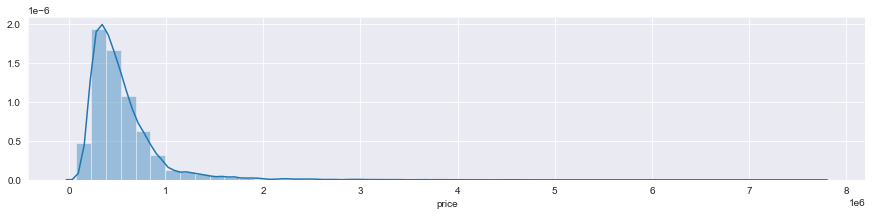

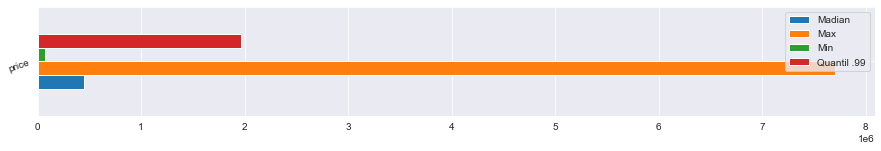

In [9]:
figure, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 3))
sns.distplot(data[target_df])
figure, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 2))
col_frequency(data, 'price' , agg=True).plot.barh(rot = 20, ax =axes)

## Corrélation

In [10]:
corr_df(data, False, 'price').T

sqft_living  grade  sqft_above  sqft_living15  bathrooms  view  \
price          0.7   0.67        0.61           0.59       0.53   0.4   

       sqft_basement  bedrooms   lat  waterfront  floors  
price           0.32      0.31  0.31        0.27    0.26

**Le prix 'price'** est fortement corréler avec la  superficie de l'espace de vivre '**sqft_living**' celle des étages '**sqft_above**',et moins avec les superficie du sous sols '**sqft_basement**' et '**floors**', La maison de plain pied ont un meilleur prix.

**Le prix 'price'** est fortement corréler avec nombre de salle d'eau '**bathrooms**' moins qu'avec le nombre de chambre '**bedroom**'.
Les maison mieux noté '**grade**' ont un meilleur prix '**price**'
la qualité '**view**' influence mieux le prix que **'waterfront'**

les maisons de la latitude Nord (Positif) sont plus onéreuses que ceux du Nord.

## Feature

In [11]:
data.drop('id', axis = 1, inplace = True)

## First Selection  "arranging items in some sequence"

In [12]:
date_columns     = ['date', 'yr_built', 'yr_renovated'] # years
spect_columns    = ['floors', 'bedrooms', 'bathrooms'] #house spect
area_columns     = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'] #afea
quality_columns  = ['view', 'waterfront', 'condition', 'grade']  # house quality
location_columns = ['zipcode','lat', 'long'] # adresse

### **Date columns**

**Date** changement du Dtype

In [13]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year.apply(lambda x: 0 if x == 2014 else 1)

**yr_renovated** Creation feature renovated (si 0 pas renouver sinon revouer ont mis 1)

In [14]:
data['renovated'] = data['yr_renovated'].apply(lambda x: 1 if x!=0 else 0)

**yr_built** Creation de l'age de la maison au lieu

In [15]:
this_year = 2020
data['age'] = this_year - data['yr_built'] #Creation feature Age 

In [16]:
data.drop(['yr_built', 'yr_renovated'], axis = 1 , inplace = True)
date_columns  = ['date', 'age', 'renovated']

## Corrélation

In [17]:
for col in date_columns: 
    (corr_df(data, True, col))


  Corrélation with date 
Not Hight Correlation
Not Low Correlation

  Corrélation with age 
Not Hight Correlation
Not Low Correlation

  Corrélation with renovated 
Not Hight Correlation

 Low Correlation 
   ('renovated', 'age', 0.23) 


Un Low positif corrélation age et rénovation : plus les maison sont ancienne elle sont rénover. 

### **Spect columns**

**bedrooms** Nettoyage

In [18]:
outliers = outlier(data, 'bedrooms', s=3, out=True)  
praParST('Outliers :' , outliers)
praParST('Unique :', data['bedrooms'].unique())


 Outliers : 
   [0, 33, 7, 8, 9, 10, 11] 

 Unique : 
   [ 3  2  4  5  1  6  7  0  8  9 11 10 33] 


pour moi je dois vérifie le **33** pour le reste logique avec unique() sauf pour les maisons avec **0 chambre (supposition que possibilité de loft ou hangar ??)**

In [19]:
praParST('Nombre maisons sans chambre' , data['bedrooms'][data['bedrooms'] == 0].count())


 Nombre maisons sans chambre 
   13 


In [20]:
m_square_min = sqmt_to_sqft(9) # on accepte les chambre a partir de chambre de 9m2
for ind in data['bedrooms'].index:
    if data['bedrooms'][ind] != 0 :
        if ((data['sqft_living'][ind] / data['bedrooms'][ind])) < m_square_min :
                print ('cette maison de ', data['bedrooms'][ind],' chambres dans une superficier de séjour de ', 
                       sqft_to_sqmt(data['sqft_living'][ind]),'m²', 'soit ', 
                       sqft_to_sqmt(data['sqft_living'][ind] / data['bedrooms'][ind]), 'm² par chambre')

cette maison de  33  chambres dans une superficier de séjour de  150.5 m² soit  4.56 m² par chambre


on suppose une c'est une erreur de frappe alors modifier 33 par 3 

In [21]:
data['bedrooms'].replace(33, 3, inplace = True)

**bathrooms** Nettoyage

In [22]:
praParST('Nombre maisons sans salle d eau ' ,data['bathrooms'][data['bathrooms'] == 0].count())


 Nombre maisons sans salle d eau  
   10 


avec 0 sanitaires, cela n'est est surment une erreur j'opte pour la suppression

In [23]:
data.drop(data['bathrooms'][data['bathrooms'] == 0].index, axis = 0, inplace = True)

## Corrélation

In [24]:
for col in spect_columns: 
    corr_df(data, True, col)


  Corrélation with floors 

 Hight Correlation 
   ('floors', 'sqft_above', 0.52) 

 Low Correlation 
   ('floors', 'grade', 0.46) 
   ('floors', 'sqft_living15', 0.28) 
   ('floors', 'sqft_basement', -0.25) 
   ('floors', 'condition', -0.26) 
   ('floors', 'age', -0.49) 

  Corrélation with bedrooms 

 Hight Correlation 
   ('bedrooms', 'sqft_living', 0.59) 
   ('bedrooms', 'bathrooms', 0.53) 

 Low Correlation 
   ('bedrooms', 'sqft_above', 0.49) 
   ('bedrooms', 'sqft_living15', 0.4) 
   ('bedrooms', 'grade', 0.37) 
   ('bedrooms', 'sqft_basement', 0.31) 

  Corrélation with bathrooms 

 Hight Correlation 
   ('bathrooms', 'sqft_living', 0.76) 
   ('bathrooms', 'sqft_above', 0.69) 
   ('bathrooms', 'grade', 0.67) 
   ('bathrooms', 'sqft_living15', 0.57) 
   ('bathrooms', 'floors', 0.5) 
   ('bathrooms', 'age', -0.51) 

 Low Correlation 
   ('bathrooms', 'sqft_basement', 0.28) 
   ('bathrooms', 'long', 0.23) 
   ('bathrooms', 'zipcode', -0.2) 


**Floors**
Le nombre d'étage **'floors'** augemente la superficie **'sqft_above'** contrairement a **'sqft_basement'** 
Le nombre d'étage **'floors'** augmente la qualité '**grade**' et '**condition**'
**Bedrooms**
Plus la superficie à l'étages '**sqft_above**' augmente le nombre de chambre  
Le nombre de chambre augmente la qualité **'grade'**, et le nombre des salle d'eau '**bathrooms**'
**Bathrooms**
Plus la superficie sauf du térrain '**sqft_lot**', augment le nombre de salle d'eau
Le nombre de salle d'eau augmente deux fois mieux le qualité **'grade'**
On construit moins de salle d'eau '**bathroom**' et d'étage '**floors**' dans les maison neuf **'age'**
les maison de la longitude Ouest (négatif) construit moins de salle d'eau que ceux de l'Est. 

### **Area Columns**

on a déja constat que la superfiice du séjour ('sqft_living') est la somme du sous sol et des étages ('sqft_basement' + 'sqft_above'), on vérifer notre dataset

In [25]:
data[area_columns][(data['sqft_basement'] + data['sqft_above']) != (data['sqft_living'])].head()

Empty DataFrame
Columns: [sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15]
Index: []

vérification que les sous sols 'sqft_basement' n'est pas supérieur  que le terrain 'sqft_lot'

In [26]:
data[area_columns][data['sqft_lot'] <= data['sqft_basement']].head()

Empty DataFrame
Columns: [sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15]
Index: []

vérification que la superficie a étage 'sqft_above' n'est pas supérieur a celle du terrain pour les maison sans étages 'floors' > 1

In [27]:
data[area_columns][(data['sqft_lot'] <= data['sqft_above']) & (data['floors'] <= 1)].head()

sqft_living  sqft_lot  sqft_above  sqft_basement  sqft_living15  \
13278         1170      1105        1170              0           1380   

       sqft_lot15  
13278        1399

**cette maison sois il y a un sous sols ou plusieurs étage non signaler
j'opte pour son suppression**

In [28]:
data.drop(data[(data['sqft_lot'] <= data['sqft_above']) & (data['floors'] <= 1)].index, axis = 0, inplace = True)

In [29]:
area_by_floors = (data['sqft_above'] / data['floors'])
praParST ('superfier du Terrain : ', (data['sqft_lot'][(data['sqft_lot'] <= area_by_floors) & (data['sqft_basement'] == 0)].values))
praParST ('superfier par étage', area_by_floors[(data['sqft_lot'] <= area_by_floors) & (data['sqft_basement'] == 0)].values)


 superfier du Terrain :  
   [520] 

 superfier par étage 
   [1613.33333333] 


**dans cette maison la superficie du Terrain 'sqft_lot' est bcp trop petite par rapport au superficie d'un étage ('sqft_above'/'floors') j'opte pour la suppression.**

In [30]:
data.drop((area_by_floors[(data['sqft_lot'] <= area_by_floors) & (data['sqft_basement'] == 0)].index), axis = 0, inplace = True)

In [31]:
data.drop(['sqft_living15','sqft_lot15'], axis = 1, inplace = True)
area_by_floors = ''
area_columns     = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

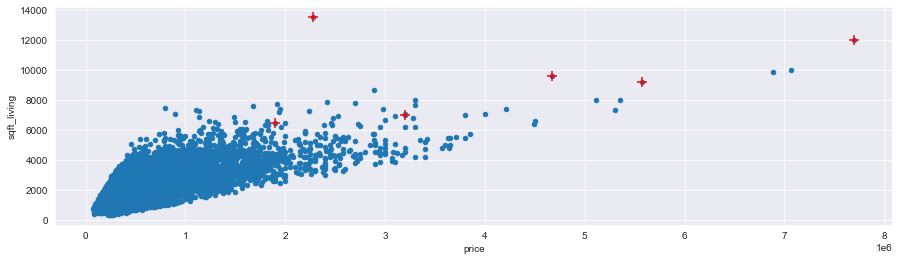

In [32]:
figure, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 4))
data.plot.scatter(x='price', y='sqft_living', ax = axes)

seuil = 6
out_list =[]
for col in area_columns:
    l = outlier(data, col, seuil)
    mask = data[data[col].isin(l)]

mask.plot.scatter(x='price', y='sqft_living', ax = axes, c = 'r', marker = '+', s  = 100)

In [33]:
data.drop(mask.index, axis = 0, inplace = True)

In [34]:
for col in area_columns: 
    corr_df(data, True, col)


  Corrélation with sqft_living 

 Hight Correlation 
   ('sqft_living', 'sqft_above', 0.88) 
   ('sqft_living', 'grade', 0.76) 

 Low Correlation 
   ('sqft_living', 'sqft_basement', 0.43) 
   ('sqft_living', 'floors', 0.36) 
   ('sqft_living', 'view', 0.28) 
   ('sqft_living', 'long', 0.24) 
   ('sqft_living', 'zipcode', -0.2) 
   ('sqft_living', 'age', -0.32) 

  Corrélation with sqft_lot 
Not Hight Correlation

 Low Correlation 
   ('sqft_lot', 'long', 0.23) 

  Corrélation with sqft_above 
Not Hight Correlation

 Low Correlation 
   ('sqft_above', 'long', 0.35) 
   ('sqft_above', 'zipcode', -0.26) 
   ('sqft_above', 'age', -0.43) 

  Corrélation with sqft_basement 
Not Hight Correlation
Not Low Correlation


La superficie des étage **'sqft_above'**  et le nombre d'étage **'floors'** augment mieux la superficie l'espace de vivre que celle de la superficie des sous sols '**sqft_basement**' la plupart des maison ne dispose pas de sous sols.
La superficie de vivre **'sqft_living'** augmente la qualité **'grade' et 'view'** 
La superficie de vivre 'fg' et **'sqft_above'** à une **Low Negatif corrélation** avec l**'âge des maison**, les maison neuf sont de plus en plus grand et avec de plus en plus étages. 
Les superficie des terrain et de l'espace de vivre des maisons de la longitude Est (positif) ont une superficie plus grand que ceux de l'Ouest.

In [35]:
prGTitle('Feature Quality : Unique data')
for col in data[quality_columns]:
    praParST(col, sorted(data[col].unique()))


  Feature Quality : Unique data 

 view 
   [0, 1, 2, 3, 4] 

 waterfront 
   [0, 1] 

 condition 
   [1, 2, 3, 4, 5] 

 grade 
   [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] 


Classement proposer pour 'condition et 'view :
(Excellent  4. — Très bien, 3 — Bien, 2 — Assez bien, 1 — Médiocre, 0.)

In [36]:
a = data['condition'].apply(lambda x: x-1)

## Corrélation

In [37]:
for col in quality_columns: 
    corr_df(data, True, col)


  Corrélation with view 
Not Hight Correlation

 Low Correlation 
   ('view', 'sqft_basement', 0.27) 
   ('view', 'grade', 0.25) 

  Corrélation with waterfront 
Not Hight Correlation

 Low Correlation 
   ('waterfront', 'view', 0.4) 

  Corrélation with condition 
Not Hight Correlation

 Low Correlation 
   ('condition', 'age', 0.36) 

  Corrélation with grade 

 Hight Correlation 
   ('grade', 'sqft_above', 0.76) 

 Low Correlation 
   ('grade', 'long', 0.2) 
   ('grade', 'age', -0.45) 


La qualité '**view**' et la notation '**grade**' sont corréler 
L'emplacement front de mer **'waterfront'** et la superficie au sous sol '**sqft_basement**' augment la qualité le '**view**'

**L'âge de la maison** augment la qualité **'condition'** et réduit la notation de **'grade'**
La superficie à l'étage '**sqft_above**(corréler déjà avec nombre de d'étage 'floors') augment la note '**grade**'
Les Maison de la longitude Est (positif) sont mieux noté que ceux de l'Ouest.

### **Location columns**

**Création de City les noms des city au lieu des zipcodes**
on passe de 70 zipcode a 24 Cité

In [38]:
zip_usa = pd.read_excel('usazips.xlsx') #fichier des Code Postal USA

data['city_'] = data['zipcode']
data['city_'].replace(zip_usa.zip[zip_usa.zip.isin(data.zipcode.values)].unique(),
                      zip_usa.city[zip_usa.zip.isin(data.zipcode.values)], inplace = True)

zip_usa = ''

#### HotCodding des City Adress

In [39]:
hotcoding_city_ = pd.get_dummies(data['city_'])

## Corrélation

In [40]:
for col in location_columns: 
    corr_df(data, True, col)


  Corrélation with zipcode 

 Hight Correlation 
   ('zipcode', 'long', -0.56) 

 Low Correlation 
   ('zipcode', 'age', 0.35) 
   ('zipcode', 'lat', 0.27) 

  Corrélation with lat 
Not Hight Correlation
Not Low Correlation

  Corrélation with long 
Not Hight Correlation

 Low Correlation 
   ('long', 'age', -0.41) 


In [41]:
date_columns     = ['date', 'age', 'renovated']
location_columns = ['city_','lat', 'long']
spect_columns    = ['floors', 'bedrooms', 'bathrooms'] #house spect
quality_columns  = ['view', 'waterfront', 'condition', 'grade']  # house quality
area_columns     = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

# Analysis
## Relation avec Target 'price'

## Date Columns

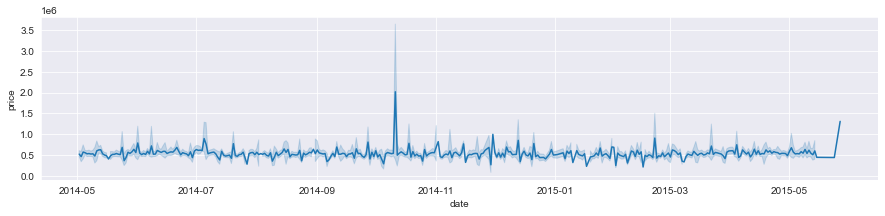

In [42]:
figure, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 3))
sns.lineplot(data=data, x = 'date', y = 'price', ax = axes)

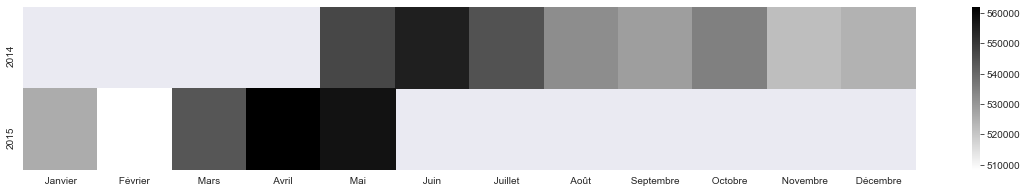

In [43]:
figure, axes = plt.subplots(nrows=1, ncols=1,figsize=(20, 3))  
month_vs_year = data.pivot_table(columns=data['month'],index=data['year'],aggfunc='mean',values='price')
month_vs_year.columns = [ ' Janvier ' , ' Février ' , ' Mars ' , ' Avril ' , ' Mai ' , ' Juin ' , ' Juillet ' , ' Août ' , ' Septembre ' , ' Octobre ' , ' Novembre ' , ' Décembre ' ]
month_vs_year.index = [2014,2015]
ax = sns.heatmap(month_vs_year, cmap = 'binary')

Le mouvement du prix est stable avec une fort hausse en octobre 2014 
Le volume est saisonnière hausse du volume de vente en **(été printemps)** baisse en **(automne hiver)**

**la maison la plus chère a étais vendu le 13 octobre 2014** 7 700 000 $ (peu expliqué la hausse)

**a noté que la date de la vente n'influence pas le prix, mais plus la volume des vente.**

In [44]:
data.drop(['date','year','month'], axis = 1, inplace = True)

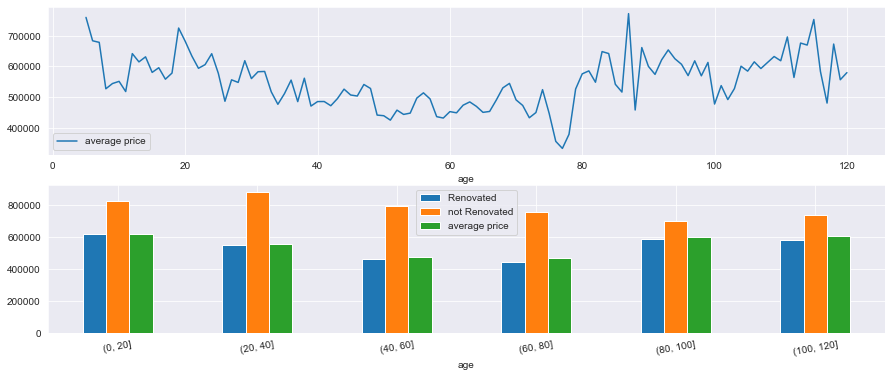

In [45]:
figure, axes = plt.subplots(nrows=2, ncols=1,figsize=(15, 6))
data.groupby(['age']).agg({'price': 'mean'}).rename(columns = {'price': 'average price'}).plot(ax = axes [0])
#data[data.age.isin([5,75,79,120])].groupby(['age']).agg({'price': 'mean'}).rename(columns = {'price': 'average price'}).plot(ax = axes [0])
t_age = pd.cut(data['age'], [ 0,20,40,60,80,100,120 ])
a = data.groupby([t_age]).agg({'price': 'mean'}).rename(columns = {'price': 'average price'})
b = data.groupby([t_age, 'renovated'], sort=False).agg({'price' : 'mean'}).unstack()
b.columns = ['Renovated ' if n == 0 else 'not Renovated' for col, n in b.columns]
b.join(a).plot.bar(rot = 10, ax = axes[1])

Les **maison neuf** est en moyenne plus cher à l’achat, son prix se déprécie plus rapidement avec le temps (entre 0 et 50 ans)
À l’inverse, d’une **maison ancienne** (de plus de 90 ans) laquelle son prix a tendance à s’apprécier dans le temps.

La **rénovation augment** le prix, 10 a 20 % en moyen, cette augmentation est plus visible pour les maison de 20 a 40 ans d'âge,

La **vendre de la maison en l’état** est en moyen 2 a 3 %  sous le prix moyen de notre échantillon

## Spect_columns

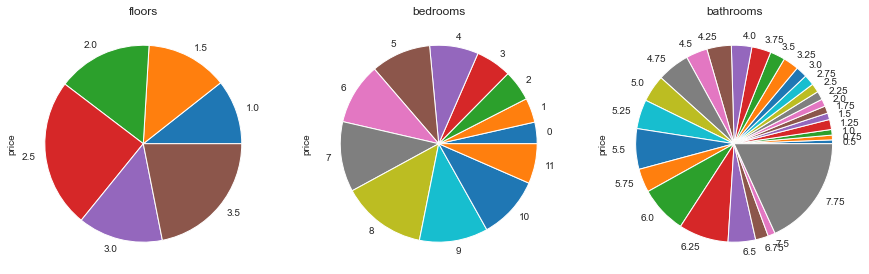

In [46]:
figure, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 9))
i=0
for col in spect_columns :
    data.groupby(col)['price'].mean().plot.pie(ax = axes[i])
    axes[i].set_title(col)
    i +=1

## Quality_columns

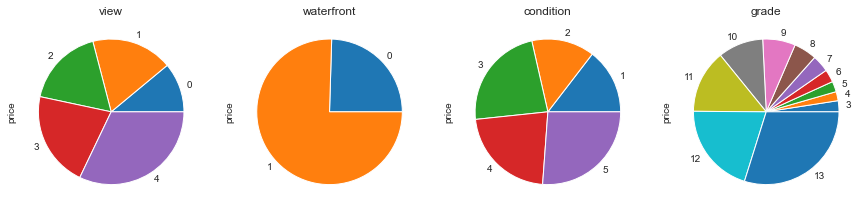

In [47]:
figure, axes = plt.subplots(nrows=1, ncols=4,figsize=(15, 9))
i=0
for col in quality_columns :
    data.groupby(col)['price'].mean().plot.pie(ax = axes[i])
    axes[i].set_title(col)
    i +=1

Une relation significative **grade/price** qui a déjà étais constater par leur corrélation, suivi de la relation **waterfront/price** 

## Location Columns

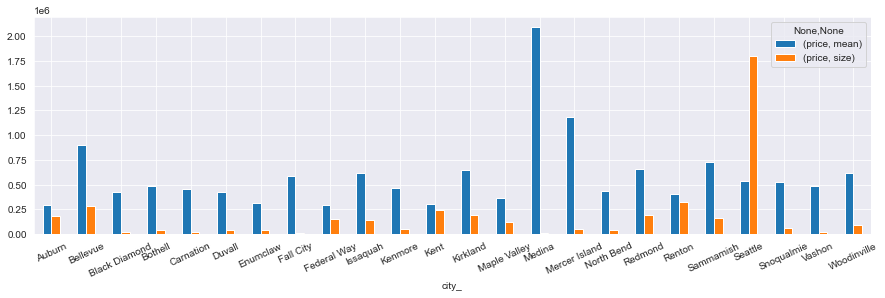

In [48]:
figure, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 4))
data.groupby(['city_'], sort=True).agg({'price': ['mean', lambda x: x.size* 200]}).rename(
    columns = {'<lambda_0>': 'size'}).plot.bar(rot = 25, ax =axes)

L'emplacement a une relation significatif avec le **price** qui est plus visible a **Medina** suivi de **Mercer Island**, où le prix moyen est élevé en relation avec le volume de vente (**price/size**) au contraire avec **Seatel** ou le prix de vente moyen est très bas en relation avec ce volume.

In [49]:
fig = px.scatter_mapbox(data, lat='lat', lon='long', color='price',
                        color_continuous_scale=px.colors.sequential.dense, size=data['price'], zoom=10, size_max=15, 
                        hover_data = ['city_','price'])
fig.update_layout(mapbox_style="carto-positron")
fig.show()

la relation **Latitude/Price** est Visible ici où on constat que les maisons **Nord** valent plus chère que ceux du **Sud**, l'emplacement **waterfront**  donne aussi ne valeur ajouter aux maisons



## Area_columns

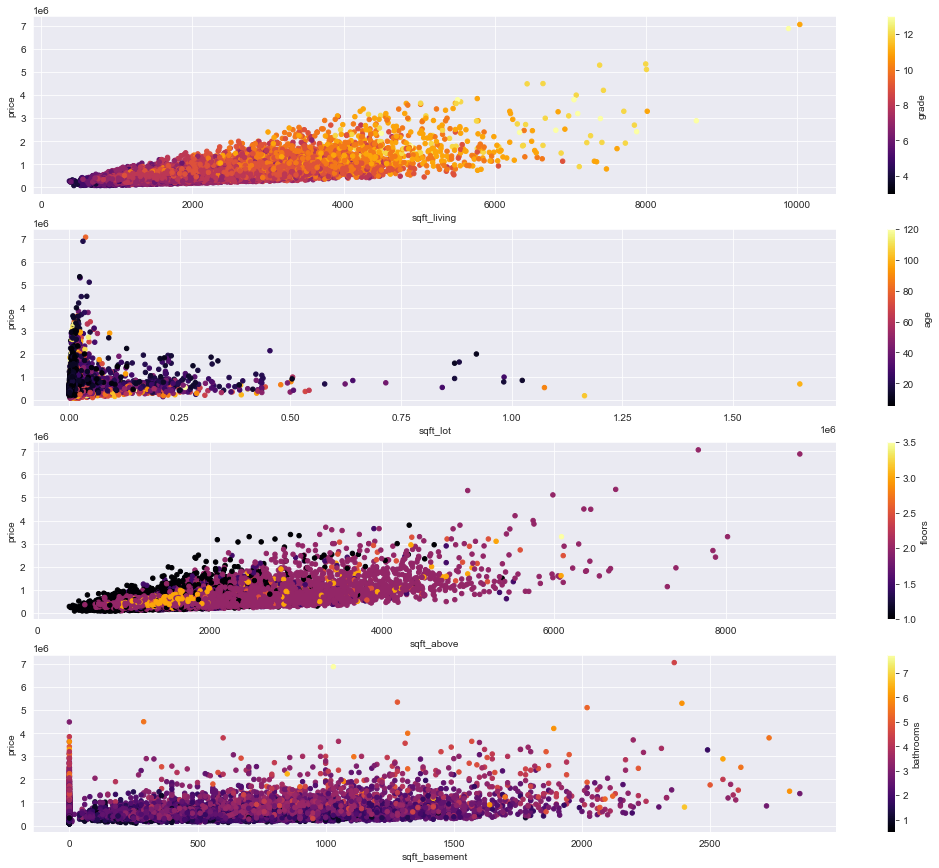

In [50]:
figure, axes = plt.subplots(nrows=4, ncols=1,figsize=(18, 15))
data.plot.scatter(y='price', x='sqft_living', c='grade',  colormap='inferno', ax = axes[0])
data.plot.scatter(y='price', x='sqft_lot',    c='age',   colormap='inferno', ax = axes[1])
data.plot.scatter(y='price', x='sqft_above',  c='floors',     colormap='inferno', ax = axes[2])
data.plot.scatter(y='price', x='sqft_basement', c='bathrooms',   colormap='inferno', ax = axes[3])

La superficie **sqft_livingt/price**  relation positive augmentation du prix est aussi le grade de la maison.

La superficie **sqft_lot/price** a une relation presque insignifiante

La superficie **sqft_above/price** une augmentation des prix pour les maison avec le moins d'étage 'floors'

 La superficie **sqft_bassement/price** un nombre important de maison sans sous sols qui on même atteint le prix de 4.5 millions de dollars,  ce feature relative avec le price mais plus en relation avec d'autre featrues.



# Select Features

**Pour la selection j'ai choisi de combiné deux méthodes :**

1- **Avec bibliothèque scikit-learn/SelectKBest de tests de régression linéaire univariée qui retour les scores p-values sur tous les Features et ici j'ai choisi la fonction de regression pour rester dans l'esprit du cours.**

2- **La corrélation indique comment les Features sont liées au Target
Aussi on a choisi les features avec qui ont un hight correlation avec notre Target 'price'**

## Selection avec sk-learn 
### SelectKBest

In [51]:
X = data.drop(['price','city_'], axis = 1)
y = data['price']

bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,y)

f_Scores = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(fit.scores_)],axis=1)
f_Scores.columns = ['features','p-values']
f_Scores= f_Scores.sort_values(by = 'p-values', ascending=False).set_index('features').head(14)
f_Scores.T

features   sqft_living         grade    sqft_above    bathrooms         view  \
p-values  20461.157444  17591.212651  12367.358841  8085.706848  4028.513021   

features    bedrooms         lat  sqft_basement  waterfront       floors  \
p-values  2394.65085  2320.20145    2311.569429  1606.91902  1554.791864   

features   renovated    sqft_lot      age  zipcode  
p-values  326.121477  173.261795  66.5993  62.5512

In [52]:
sel_KBest = list(f_Scores.index)

## Selection avec la coorélation

In [53]:
corelation = corr_df(data, False, 'price')
corelation.T

sqft_living  grade  sqft_above  bathrooms  view  bedrooms   lat  \
price          0.7   0.67         0.6       0.52   0.4      0.32  0.31   

       sqft_basement  floors  waterfront  
price           0.31    0.26        0.26

In [54]:
sel_corr = list(corelation.index)

### Combiner les deux choix

In [55]:
select = ['sqft_living',  'sqft_above', 'sqft_basement', 
          'lat',
          'grade', 'view', 'waterfront',
          'bathrooms',  'bedrooms',  'floors',
          'age','renovated' ]

(floors,renovated,sqft_lot,age,zipcode) il on un mauvais P_value

floors a une bonne corrélation avec sqft_above ce qui explique de la rajouter
age, et renovated on tout les deux une bonne corrélation avec le grade
pour le zipcodes ces valeur ordinal on un peux forcé son p-value mais on le récupère en utilisons le OnHotCoder de city_

le sqft_lot par contre on ne le récupère pas

In [56]:
target = data[target_df][:,np.newaxis]

In [57]:
feature = pd.concat([data,hotcoding_city_], axis = 1)
select += list(hotcoding_city_.columns)
feature = feature[select]

In [58]:
del data

# Standardisation

In [59]:
std_scaler = preprocessing.StandardScaler()

In [60]:
for col in feature.drop(hotcoding_city_.columns, axis = 1, inplace = False) :
    feature[col] = (std_scaler.fit_transform(feature[col].values[:,np.newaxis]))

In [61]:
target = std_scaler.fit_transform(target)

# Model de Machine Learning

## Linear Regression

In [62]:
Col_F, MSE, R2 = [],[],[]

model_reg = LinearRegression() 
for col in feature:
    X = feature[col].values[:,np.newaxis]
    y = target

    size = 0.20
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=size,random_state=0)

    model_reg.fit(X_train,y_train) 
    
    y_predict = model_reg.predict(X_test)  
    Col_F.append(col)
    MSE.append(mean_squared_error(y_test,y_predict))
    R2.append(metrics.r2_score(y_test,y_predict))
f_Scores = pd.concat([pd.DataFrame(Col_F),pd.DataFrame(MSE),pd.DataFrame(R2)],axis=1)
f_Scores.columns = ['Feature','MeanSquaredError', 'R squared Score']
f_Scores = f_Scores.sort_values(by = 'R squared Score', ascending=False)
f_Scores.T

0         4           1          7       5   \
Feature           sqft_living     grade  sqft_above  bathrooms    view   
MeanSquaredError     0.481984  0.526969    0.599389   0.691886  0.8006   
R squared Score      0.485145  0.437093    0.359733   0.260928  0.1448   

                        3         8              2          13          6   \
Feature                lat  bedrooms  sqft_basement   Bellevue  waterfront   
MeanSquaredError  0.841418  0.842402       0.842484   0.858283    0.866828   
R squared Score   0.101198  0.100147        0.10006  0.0831831   0.0740551   

                  ...           17             14           16           22  \
Feature           ...       Duvall  Black Diamond    Carnation      Kenmore   
MeanSquaredError  ...     0.935561       0.935573     0.935796     0.935833   
R squared Score   ...  0.000634364    0.000621517  0.000383518  0.000344422   

                           10           15          32           19  \
Feature                   age      Bothell     Seattle    Fall City   
MeanSquaredError     0.935833     0.936031    0.936121     0.936287   
R squared Score   0.000344183  0.000132343  3.6832e-05 -0.000140735   

                           33           34  
Feature            Snoqualmie       Vashon  
MeanSquaredError     0.936317     0.936318  
R squared Score  -0.000173367 -0.000174511  

[3 rows x 36 columns]

### Individuellement les features : sqft_living est un bonne indicateur avec son score de 0.48  suivi par grade 0.43  et sqft_above 0.36, ce model de prédiction qui donne un résultat de maximum 0.48, ni pas un model utilisable. 

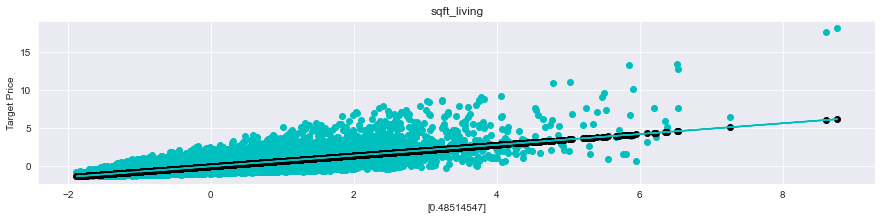

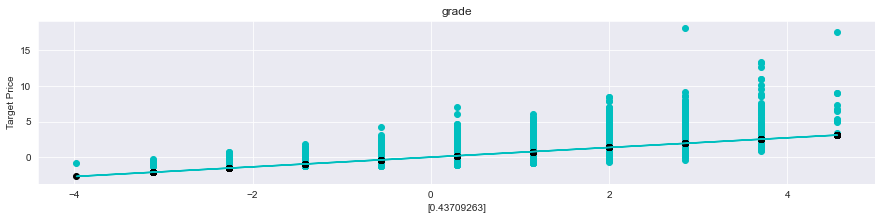

In [63]:
i=0
for col in f_Scores.Feature:
    if  i <= 1:
        X = feature[col].values[:,np.newaxis]
        y = target
        size = 0.20
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=size,random_state=0)

        model_reg.fit(X_train,y_train) 
           
        plt.subplots(nrows=1, ncols=1,figsize=(15, 3))
        plt.scatter(X,y,color='c')
        plt.scatter(X,model_reg.predict(X),color="k")
        plt.plot(X,model_reg.predict(X),color="c")
        titre = f_Scores['R squared Score'][f_Scores.Feature == col]
        plt.xlabel(str(titre.values))
        plt.ylabel('Target Price')
        plt.title(col)
        plt.show()
    i+=1  

## Multi-Linear Regression

In [64]:
X = feature
y = target

In [65]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=size,random_state=0)

In [66]:
model_multi = LinearRegression() 
model_multi.fit(X_train,y_train)                  

LinearRegression()

In [67]:
y_predict = model_multi.predict(X_test)       
print (f"{'Interception:' :-<25} {model_multi.intercept_}")
print (f"{'Coefficients:' :-<25} {model_multi.coef_}")
print (f"{'MeanSquaredError:' :-<25} {mean_squared_error(y_test,y_predict)}")
print (f"{'R squared:' :-<25} {metrics.r2_score(y_test,y_predict)}")

Interception:------------ [0.06056977]
Coefficients:------------ [[-1.05214367e+11  9.54223628e+10  5.08277465e+10  2.35910606e-01
   2.87998461e-01  1.11657445e-01  1.37666382e-01  8.72486560e-02
  -8.92397494e-02  1.16848007e-02  1.89419240e-01  8.60247901e-04
  -9.77910766e-02  4.28484038e-01  9.32904469e-02 -5.36246008e-01
  -3.75349661e-01 -5.70529677e-01  5.89964713e-02 -1.07411533e-01
  -1.78724420e-01 -1.95990726e-02 -5.42237225e-01 -1.61336394e-01
  -1.99211946e-02 -9.30332073e-02  2.94471766e+00  8.26389880e-01
  -1.06266584e-01 -1.51335390e-01 -1.86096977e-01 -1.83683403e-01
  -4.37151307e-02 -2.32011354e-01 -2.62350618e-01 -4.84240988e-01]]
MeanSquaredError:-------- 0.24963423618654948
R squared:--------------- 0.7333409322696676


### Ce model de prédiction avec l'utilisation des **plus de feature** donne des meilleurs scrore qui a atteint le **chiffre de  0.73** peut être utilisable pour prédire le prix des maison

## Polynomial regression

In [68]:
feature.drop(hotcoding_city_.columns, axis = 1, inplace = True)
Col_F, MSE, R2 = [],[],[]

poly = PolynomialFeatures(degree = 4)
model_poly = LinearRegression()
    
for col in feature:
    X = feature[col].values[:,np.newaxis]
    y = target

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=size,random_state=0)
    
    X_poly = poly.fit_transform(X_train)
    poly.fit(X_poly,y) 

    model_poly.fit(X_poly,y_train)
    
    y_predict = model_poly.predict(poly.fit_transform(X_test))  
    Col_F.append(col)
    MSE.append(mean_squared_error(y_test,y_predict))
    R2.append(metrics.r2_score(y_test,y_predict))

f_Scores = pd.concat([pd.DataFrame(Col_F),pd.DataFrame(MSE),pd.DataFrame(R2)],axis=1)
f_Scores.columns = ['Feature','MeanSquaredError', 'R squared Score']
f_Scores = f_Scores.sort_values(by = 'R squared Score', ascending=False)
f_Scores.T

0         4           1          7         3   \
Feature           sqft_living     grade  sqft_above  bathrooms       lat   
MeanSquaredError     0.436607  0.483034     0.56912   0.647388     0.741   
R squared Score      0.533616  0.484024    0.392067   0.308461  0.208465   

                        5              2         8          9           6   \
Feature               view  sqft_basement  bedrooms     floors  waterfront   
MeanSquaredError  0.800533       0.813848  0.838042   0.861855    0.866823   
R squared Score   0.144871       0.130648  0.104805  0.0793675   0.0740601   

                         10         11  
Feature                 age  renovated  
MeanSquaredError   0.915817   0.917116  
R squared Score   0.0217256  0.0203372

### Le model Polynomial donne un meilleur résultat que celui de Model Lineaire ex du feature sqft_living 0.53 contre 0.48 mais le model Multi-Linear reste avec le meilleur score 0.73

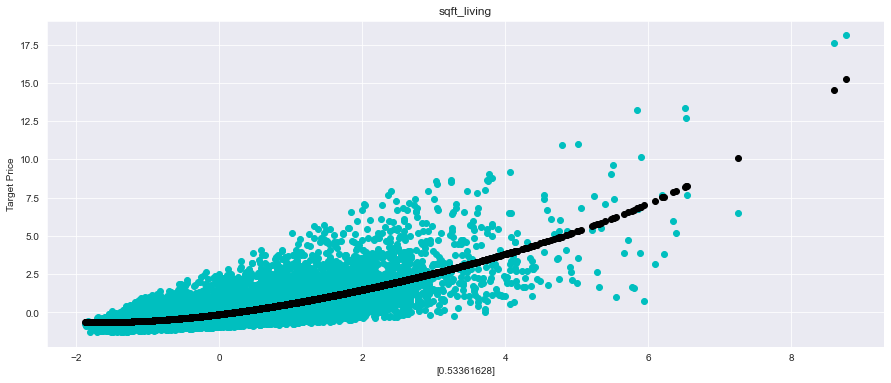

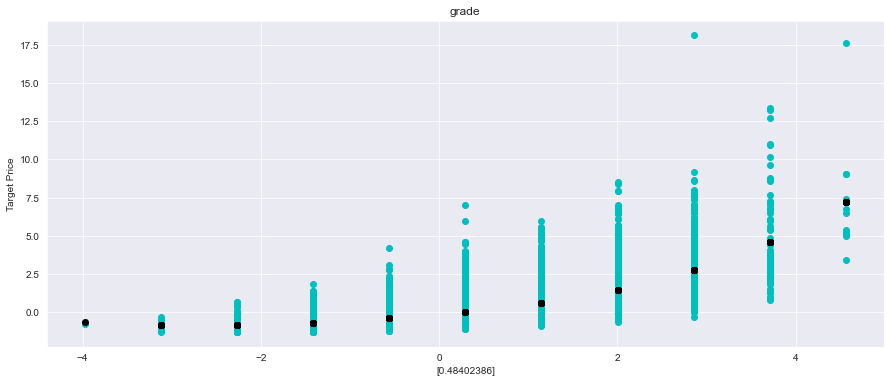

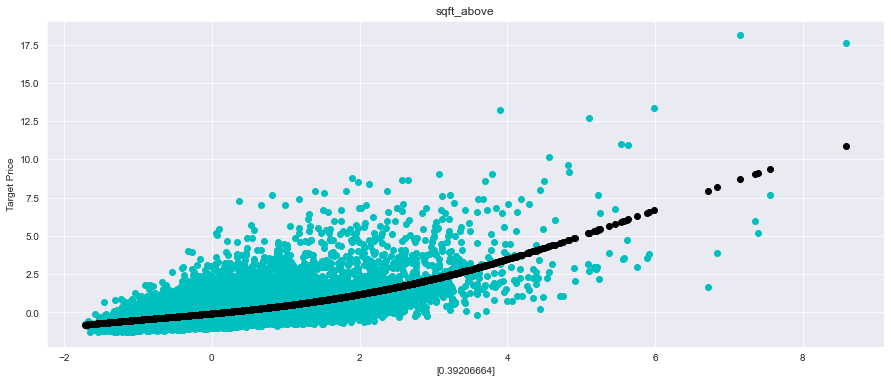

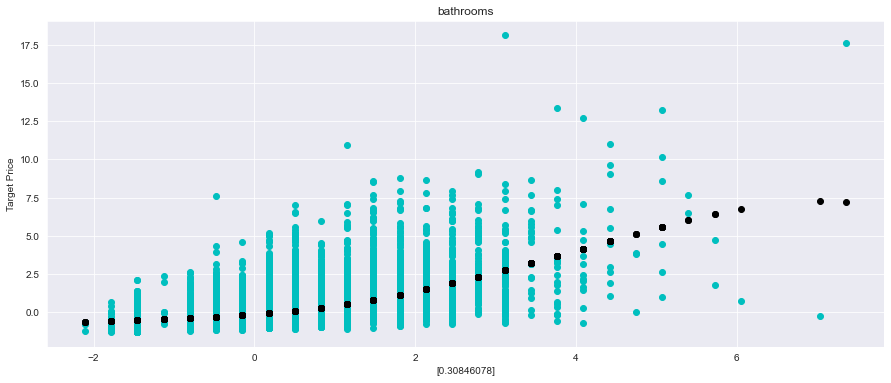

In [69]:
i=0
for col in f_Scores.Feature:
    if  i <= 3:
        X = feature[col].values[:,np.newaxis]
        y = target
        size = 0.20
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=size,random_state=0)

        X_poly = poly.fit_transform(X_train)
        poly.fit(X_poly,y) 

        model_poly.fit(X_poly,y_train)
        
        plt.subplots(nrows=1, ncols=1,figsize=(15, 6))
        plt.scatter(X,y,color="c")
        plt.scatter(X,model_poly.predict(poly.fit_transform(X)),color="k")

        titre = f_Scores['R squared Score'][f_Scores.Feature == col]
        plt.xlabel(str(titre.values))
        plt.ylabel('Target Price')
        plt.title(col)
        plt.show()
        i+=1    